## LDA

Using LDA to find hidden topics from the hotel reviews and the impact topic has on review score.


#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import warnings
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim import similarities
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

import spacy


import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud


ModuleNotFoundError: No module named 'pyLDAvis'

In [2]:
data = pd.read_csv('review_df1.csv')
len(data)

3520

## Pre-process data

In [3]:
# Convert the words to lowercase
data['P_Review_lower'] = data['Positive_Review'].str.lower()

# stop word list
stop_list = nltk.corpus.stopwords.words('english')
stop_list_extra = ['negative', 'positive', 'could', 'like', 'look', 'done', 'bit', 'everything', 'maybe', 'also', 'good', 'great', 'excellent', 'perfect',
                 'hotel', 'really', 'little', 'lot', 'would', 'go', 'even', 'nothing', 'especially','definitely',
                 'room', 'location', 'love', 'stay', 'instead', 'extremely', 'very']
stop_list.extend(stop_list_extra)

# Process
data['P_Review_tokenize'] = data['P_Review_lower'].apply(lambda x: nltk.word_tokenize(x))
data['P_Review_word'] = data['P_Review_tokenize'].apply(lambda x: [w for w in x if re.search('^[a-z]+$', w)])
data['P_Review_nostop'] = data['P_Review_word'].apply(lambda x: [w for w in x if w not in stop_list])
data['P_Review_lemmatize'] = data['P_Review_nostop'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
data['P_Review_stem'] = data['P_Review_lemmatize'].apply(lambda x: [stemmer.stem(w) for w in x])
data['P_Review_clean'] = data['P_Review_stem'].apply(lambda x: [w for w in x if len(w)>3])

data['P_Review_clean'].head()


0            [bathroom, given, quieter, rear, request]
1                       [hyde, park, paddington, need]
2    [wonder, price, decent, size, comfi, central, ...
3    [bathroom, favourit, mayfair, kitchen, food, a...
4                                        [worst, stay]
Name: P_Review_clean, dtype: object

In [4]:
p_reviews = data['P_Review_clean']
p_reviews.head()

0            [bathroom, given, quieter, rear, request]
1                       [hyde, park, paddington, need]
2    [wonder, price, decent, size, comfi, central, ...
3    [bathroom, favourit, mayfair, kitchen, food, a...
4                                        [worst, stay]
Name: P_Review_clean, dtype: object

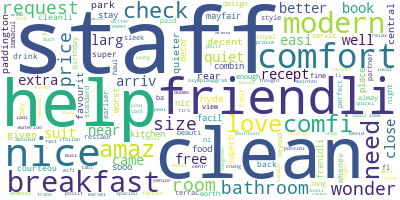

In [5]:
# Join the different processed titles together.
long_string = str(p_reviews)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Using wordcloud can help us identify more words to add to the stop list

In [6]:
p_dictionary = corpora.Dictionary(p_reviews)
print(p_dictionary)

Dictionary(2728 unique tokens: ['bathroom', 'given', 'quieter', 'rear', 'request']...)


In [7]:
p_corpus = [p_dictionary.doc2bow(review) for review in p_reviews]

## Gensim LDA model

In [194]:
#NUM_TOPICS = 9 
#ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

In [195]:
#topics = ldamodel.show_topics()
#for topic in topics:
#    print(topic)

In [196]:
#word_dict = {};
#for i in range(NUM_TOPICS):
#    words = ldamodel.show_topic(i, topn = 20)
#    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
#pd.DataFrame(word_dict)

In [197]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)

In [198]:
# Compute Perplexity
#print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)

### Let's go straight to LDA mallet since results are usually better.

In [46]:
#LDA mallet
import os
os.environ.update({'MALLET_HOME':r'C:/nltk_data/mallet/mallet-2.0.8/'})

mallet_path = r'C:/nltk_data/mallet/mallet-2.0.8/bin/mallet' # update this path
p_ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=p_corpus, num_topics=3, id2word=p_dictionary)

In [47]:
# Show Topics
pprint(p_ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_p_ldamallet = CoherenceModel(model=p_ldamallet, texts=p_reviews, dictionary=p_dictionary, coherence='c_v')
coherence_p_ldamallet = coherence_model_p_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_p_ldamallet)

[(0,
  [('nice', 0.07637448132780084),
   ('station', 0.0333246887966805),
   ('close', 0.03241701244813278),
   ('walk', 0.030731327800829874),
   ('clean', 0.027100622406639005),
   ('quiet', 0.02398858921161826),
   ('restaur', 0.02321058091286307),
   ('area', 0.021784232365145227),
   ('modern', 0.017764522821576763),
   ('citi', 0.017634854771784232)]),
 (1,
  [('staff', 0.1220222339862361),
   ('breakfast', 0.08615669666490207),
   ('friendli', 0.08020116463737427),
   ('love', 0.042482795129698256),
   ('comfort', 0.031101111699311804),
   ('facil', 0.016013763896241397),
   ('free', 0.014557967178401271),
   ('decor', 0.014557967178401271),
   ('food', 0.014293276866066702),
   ('small', 0.013763896241397565)]),
 (2,
  [('staff', 0.05641972053783285),
   ('room', 0.039810176641181125),
   ('clean', 0.039282889533350906),
   ('comfort', 0.0330872660163459),
   ('servic', 0.02649617716846823),
   ('view', 0.02412338518323227),
   ('comfi', 0.022277880305826524),
   ('amaz', 0.01

In [13]:
word_dict = {};
for i in range(3):
    words = p_ldamallet.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03
0,station,staff,clean
1,close,breakfast,comfort
2,walk,friendli,love
3,quiet,nice,room
4,restaur,servic,view
5,london,check,staff
6,citi,facil,comfi
7,central,free,area
8,easi,food,amaz
9,tube,shower,modern


## Ensure topic numbers is feasible by plotting coherence graph

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=p_dictionary, corpus=p_corpus, texts=p_reviews, start=2, limit=8, step=1)

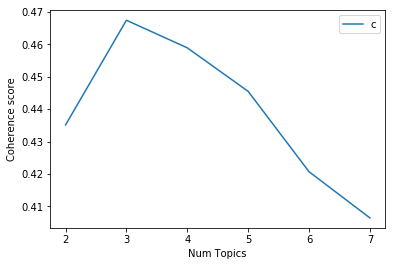

In [52]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Generate topic probability distribution for each review

In [39]:
for i in range(3):
    col_name = 'p_review_topic_'+str(i)
    data[col_name] = 0


In [40]:
for row_index, row in data.iterrows():
    row = row.copy()
    new_doc = p_dictionary.doc2bow(row['P_Review_clean'])
    lda_result = p_ldamallet[new_doc]
    for tpc in lda_result:
        col_name = 'p_review_topic_'+(str(tpc[0]).strip())
        print(row_index,col_name, tpc[1])
        data.loc[row_index,col_name] = tpc[1]

0 p_review_topic_0 0.3230452674897119
0 p_review_topic_1 0.3395061728395062
0 p_review_topic_2 0.3374485596707819
1 p_review_topic_0 0.37106918238993714
1 p_review_topic_1 0.3144654088050315
1 p_review_topic_2 0.3144654088050315
2 p_review_topic_0 0.35119047619047616
2 p_review_topic_1 0.3333333333333333
2 p_review_topic_2 0.31547619047619047
3 p_review_topic_0 0.3511904761904762
3 p_review_topic_1 0.3511904761904762
3 p_review_topic_2 0.2976190476190476
4 p_review_topic_0 0.33974358974358976
4 p_review_topic_1 0.33974358974358976
4 p_review_topic_2 0.3205128205128205
5 p_review_topic_0 0.36318407960199006
5 p_review_topic_1 0.2686567164179105
5 p_review_topic_2 0.3681592039800995
6 p_review_topic_0 0.33333333333333337
6 p_review_topic_1 0.33333333333333337
6 p_review_topic_2 0.33333333333333337
7 p_review_topic_0 0.30864197530864196
7 p_review_topic_1 0.3477366255144033
7 p_review_topic_2 0.3436213991769548
8 p_review_topic_0 0.2976190476190476
8 p_review_topic_1 0.33333333333333337
8

137 p_review_topic_1 0.3205128205128205
137 p_review_topic_2 0.33974358974358976
138 p_review_topic_0 0.3408662900188324
138 p_review_topic_1 0.3088512241054614
138 p_review_topic_2 0.3502824858757062
139 p_review_topic_0 0.3978494623655914
139 p_review_topic_1 0.2885304659498208
139 p_review_topic_2 0.31362007168458783
140 p_review_topic_0 0.3106995884773663
140 p_review_topic_1 0.34567901234567905
140 p_review_topic_2 0.3436213991769548
141 p_review_topic_0 0.3511904761904762
141 p_review_topic_1 0.2976190476190476
141 p_review_topic_2 0.3511904761904762
142 p_review_topic_0 0.33333333333333337
142 p_review_topic_1 0.33333333333333337
142 p_review_topic_2 0.33333333333333337
143 p_review_topic_0 0.3042735042735043
143 p_review_topic_1 0.36923076923076925
143 p_review_topic_2 0.3264957264957265
144 p_review_topic_0 0.326797385620915
144 p_review_topic_1 0.34640522875816987
144 p_review_topic_2 0.326797385620915
145 p_review_topic_0 0.29012345679012347
145 p_review_topic_1 0.4243827160

272 p_review_topic_2 0.3205128205128205
273 p_review_topic_0 0.33123689727463307
273 p_review_topic_1 0.3165618448637316
273 p_review_topic_2 0.35220125786163514
274 p_review_topic_0 0.3575757575757576
274 p_review_topic_1 0.3393939393939394
274 p_review_topic_2 0.303030303030303
275 p_review_topic_0 0.33333333333333337
275 p_review_topic_1 0.3144654088050315
275 p_review_topic_2 0.35220125786163525
276 p_review_topic_0 0.32051282051282054
276 p_review_topic_1 0.32051282051282054
276 p_review_topic_2 0.35897435897435903
277 p_review_topic_0 0.33697632058287796
277 p_review_topic_1 0.3624772313296903
277 p_review_topic_2 0.3005464480874317
278 p_review_topic_0 0.3881856540084389
278 p_review_topic_1 0.3389592123769339
278 p_review_topic_2 0.27285513361462727
279 p_review_topic_0 0.3450292397660819
279 p_review_topic_1 0.3450292397660819
279 p_review_topic_2 0.30994152046783624
280 p_review_topic_0 0.3065134099616858
280 p_review_topic_1 0.3659003831417625
280 p_review_topic_2 0.32758620

407 p_review_topic_1 0.3224043715846994
407 p_review_topic_2 0.3224043715846994
408 p_review_topic_0 0.3309352517985612
408 p_review_topic_1 0.25419664268585135
408 p_review_topic_2 0.4148681055155875
409 p_review_topic_0 0.3086419753086419
409 p_review_topic_1 0.36625514403292175
409 p_review_topic_2 0.3251028806584362
410 p_review_topic_0 0.28735632183908044
410 p_review_topic_1 0.339080459770115
410 p_review_topic_2 0.37356321839080453
411 p_review_topic_0 0.3144654088050315
411 p_review_topic_1 0.3144654088050315
411 p_review_topic_2 0.37106918238993714
412 p_review_topic_0 0.33333333333333337
412 p_review_topic_1 0.33333333333333337
412 p_review_topic_2 0.33333333333333337
413 p_review_topic_0 0.32398753894080995
413 p_review_topic_1 0.3333333333333333
413 p_review_topic_2 0.3426791277258567
414 p_review_topic_0 0.33974358974358976
414 p_review_topic_1 0.3205128205128205
414 p_review_topic_2 0.33974358974358976
415 p_review_topic_0 0.339080459770115
415 p_review_topic_1 0.32567049

542 p_review_topic_0 0.35220125786163525
542 p_review_topic_1 0.33333333333333337
542 p_review_topic_2 0.3144654088050315
543 p_review_topic_0 0.33333333333333337
543 p_review_topic_1 0.33333333333333337
543 p_review_topic_2 0.33333333333333337
544 p_review_topic_0 0.3212121212121212
544 p_review_topic_1 0.3434343434343434
544 p_review_topic_2 0.33535353535353535
545 p_review_topic_0 0.33333333333333337
545 p_review_topic_1 0.33333333333333337
545 p_review_topic_2 0.33333333333333337
546 p_review_topic_0 0.339080459770115
546 p_review_topic_1 0.3735632183908046
546 p_review_topic_2 0.2873563218390805
547 p_review_topic_0 0.34640522875816987
547 p_review_topic_1 0.326797385620915
547 p_review_topic_2 0.326797385620915
548 p_review_topic_0 0.30303030303030304
548 p_review_topic_1 0.3434343434343435
548 p_review_topic_2 0.3535353535353536
549 p_review_topic_0 0.33974358974358976
549 p_review_topic_1 0.33974358974358976
549 p_review_topic_2 0.3205128205128205
550 p_review_topic_0 0.3333333

676 p_review_topic_2 0.3464052287581699
677 p_review_topic_0 0.3205128205128205
677 p_review_topic_1 0.33974358974358976
677 p_review_topic_2 0.33974358974358976
678 p_review_topic_0 0.30994152046783624
678 p_review_topic_1 0.33138401559454195
678 p_review_topic_2 0.3586744639376218
679 p_review_topic_0 0.29943502824858753
679 p_review_topic_1 0.3691148775894538
679 p_review_topic_2 0.3314500941619586
680 p_review_topic_0 0.3757575757575758
680 p_review_topic_1 0.3212121212121212
680 p_review_topic_2 0.30303030303030304
681 p_review_topic_0 0.326797385620915
681 p_review_topic_1 0.34640522875816987
681 p_review_topic_2 0.326797385620915
682 p_review_topic_0 0.3163841807909605
682 p_review_topic_1 0.33333333333333337
682 p_review_topic_2 0.3502824858757062
683 p_review_topic_0 0.30864197530864196
683 p_review_topic_1 0.3106995884773663
683 p_review_topic_2 0.38065843621399176
684 p_review_topic_0 0.34567901234567905
684 p_review_topic_1 0.3106995884773663
684 p_review_topic_2 0.34362139

811 p_review_topic_1 0.29508196721311475
811 p_review_topic_2 0.3442622950819672
812 p_review_topic_0 0.35220125786163525
812 p_review_topic_1 0.3144654088050315
812 p_review_topic_2 0.33333333333333337
813 p_review_topic_0 0.34640522875816987
813 p_review_topic_1 0.326797385620915
813 p_review_topic_2 0.326797385620915
814 p_review_topic_0 0.297979797979798
814 p_review_topic_1 0.2693602693602694
814 p_review_topic_2 0.4326599326599327
815 p_review_topic_0 0.3224043715846994
815 p_review_topic_1 0.2914389799635701
815 p_review_topic_2 0.3861566484517304
816 p_review_topic_0 0.33333333333333337
816 p_review_topic_1 0.33333333333333337
816 p_review_topic_2 0.33333333333333337
817 p_review_topic_0 0.3086419753086419
817 p_review_topic_1 0.3518518518518518
817 p_review_topic_2 0.3395061728395061
818 p_review_topic_0 0.34640522875816987
818 p_review_topic_1 0.326797385620915
818 p_review_topic_2 0.326797385620915
819 p_review_topic_0 0.3144654088050315
819 p_review_topic_1 0.31446540880503

946 p_review_topic_0 0.33974358974358976
946 p_review_topic_1 0.3205128205128205
946 p_review_topic_2 0.33974358974358976
947 p_review_topic_0 0.36008230452674894
947 p_review_topic_1 0.3271604938271605
947 p_review_topic_2 0.31275720164609055
948 p_review_topic_0 0.33333333333333337
948 p_review_topic_1 0.36904761904761907
948 p_review_topic_2 0.2976190476190476
949 p_review_topic_0 0.32716049382716056
949 p_review_topic_1 0.32921810699588483
949 p_review_topic_2 0.3436213991769548
950 p_review_topic_0 0.32679738562091504
950 p_review_topic_1 0.32679738562091504
950 p_review_topic_2 0.3464052287581699
951 p_review_topic_0 0.326797385620915
951 p_review_topic_1 0.34640522875816987
951 p_review_topic_2 0.326797385620915
952 p_review_topic_0 0.30303030303030304
952 p_review_topic_1 0.3232323232323232
952 p_review_topic_2 0.3737373737373737
953 p_review_topic_0 0.358974358974359
953 p_review_topic_1 0.3205128205128205
953 p_review_topic_2 0.3205128205128205
954 p_review_topic_0 0.33333333

1079 p_review_topic_0 0.3349673202614379
1079 p_review_topic_1 0.34967320261437906
1079 p_review_topic_2 0.31535947712418294
1080 p_review_topic_0 0.33333333333333337
1080 p_review_topic_1 0.33333333333333337
1080 p_review_topic_2 0.33333333333333337
1081 p_review_topic_0 0.35220125786163525
1081 p_review_topic_1 0.33333333333333337
1081 p_review_topic_2 0.3144654088050315
1082 p_review_topic_0 0.3274853801169591
1082 p_review_topic_1 0.33138401559454195
1082 p_review_topic_2 0.34113060428849906
1083 p_review_topic_0 0.3271604938271605
1083 p_review_topic_1 0.35185185185185186
1083 p_review_topic_2 0.32098765432098764
1084 p_review_topic_0 0.3436213991769548
1084 p_review_topic_1 0.33539094650205764
1084 p_review_topic_2 0.3209876543209877
1085 p_review_topic_0 0.3059360730593607
1085 p_review_topic_1 0.3576864535768645
1085 p_review_topic_2 0.3363774733637747
1086 p_review_topic_0 0.30994152046783624
1086 p_review_topic_1 0.3801169590643274
1086 p_review_topic_2 0.30994152046783624
10

1210 p_review_topic_1 0.3656565656565657
1210 p_review_topic_2 0.33131313131313134
1211 p_review_topic_0 0.3242258652094718
1211 p_review_topic_1 0.35701275045537334
1211 p_review_topic_2 0.31876138433515483
1212 p_review_topic_0 0.33974358974358976
1212 p_review_topic_1 0.3205128205128205
1212 p_review_topic_2 0.33974358974358976
1213 p_review_topic_0 0.33333333333333337
1213 p_review_topic_1 0.33333333333333337
1213 p_review_topic_2 0.33333333333333337
1214 p_review_topic_0 0.2885304659498208
1214 p_review_topic_1 0.37813620071684584
1214 p_review_topic_2 0.3333333333333333
1215 p_review_topic_0 0.34640522875816987
1215 p_review_topic_1 0.326797385620915
1215 p_review_topic_2 0.326797385620915
1216 p_review_topic_0 0.3205128205128205
1216 p_review_topic_1 0.33974358974358976
1216 p_review_topic_2 0.33974358974358976
1217 p_review_topic_0 0.3092369477911647
1217 p_review_topic_1 0.3239625167336011
1217 p_review_topic_2 0.36680053547523433
1218 p_review_topic_0 0.33333333333333337
1218

1342 p_review_topic_0 0.33333333333333337
1342 p_review_topic_1 0.3144654088050315
1342 p_review_topic_2 0.35220125786163525
1343 p_review_topic_0 0.33974358974358976
1343 p_review_topic_1 0.3205128205128205
1343 p_review_topic_2 0.33974358974358976
1344 p_review_topic_0 0.24875621890547264
1344 p_review_topic_1 0.31343283582089554
1344 p_review_topic_2 0.43781094527363185
1345 p_review_topic_0 0.3154761904761905
1345 p_review_topic_1 0.33333333333333337
1345 p_review_topic_2 0.3511904761904762
1346 p_review_topic_0 0.350104821802935
1346 p_review_topic_1 0.31865828092243187
1346 p_review_topic_2 0.3312368972746331
1347 p_review_topic_0 0.34313725490196073
1347 p_review_topic_1 0.3676470588235294
1347 p_review_topic_2 0.28921568627450983
1348 p_review_topic_0 0.33333333333333337
1348 p_review_topic_1 0.33333333333333337
1348 p_review_topic_2 0.33333333333333337
1349 p_review_topic_0 0.37106918238993714
1349 p_review_topic_1 0.3144654088050315
1349 p_review_topic_2 0.3144654088050315
13

1473 p_review_topic_1 0.31384015594541914
1473 p_review_topic_2 0.3937621832358674
1474 p_review_topic_0 0.35959595959595964
1474 p_review_topic_1 0.3373737373737374
1474 p_review_topic_2 0.30303030303030304
1475 p_review_topic_0 0.32679738562091504
1475 p_review_topic_1 0.32679738562091504
1475 p_review_topic_2 0.3464052287581699
1476 p_review_topic_0 0.3597883597883598
1476 p_review_topic_1 0.28218694885361556
1476 p_review_topic_2 0.3580246913580247
1477 p_review_topic_0 0.4092592592592592
1477 p_review_topic_1 0.30185185185185187
1477 p_review_topic_2 0.28888888888888886
1478 p_review_topic_0 0.339080459770115
1478 p_review_topic_1 0.30842911877394635
1478 p_review_topic_2 0.35249042145593873
1479 p_review_topic_0 0.31446540880503143
1479 p_review_topic_1 0.3542976939203354
1479 p_review_topic_2 0.3312368972746331
1480 p_review_topic_0 0.2996632996632997
1480 p_review_topic_1 0.3754208754208754
1480 p_review_topic_2 0.3249158249158249
1481 p_review_topic_0 0.326797385620915
1481 p_

1604 p_review_topic_2 0.3144654088050315
1605 p_review_topic_0 0.39526411657559196
1605 p_review_topic_1 0.3151183970856102
1605 p_review_topic_2 0.2896174863387978
1606 p_review_topic_0 0.32748538011695905
1606 p_review_topic_1 0.32943469785575047
1606 p_review_topic_2 0.34307992202729043
1607 p_review_topic_0 0.37749287749287747
1607 p_review_topic_1 0.3119658119658119
1607 p_review_topic_2 0.3105413105413105
1608 p_review_topic_0 0.3817204301075269
1608 p_review_topic_1 0.2849462365591398
1608 p_review_topic_2 0.3333333333333333
1609 p_review_topic_0 0.32679738562091504
1609 p_review_topic_1 0.32679738562091504
1609 p_review_topic_2 0.3464052287581699
1610 p_review_topic_0 0.33333333333333337
1610 p_review_topic_1 0.35220125786163525
1610 p_review_topic_2 0.3144654088050315
1611 p_review_topic_0 0.33333333333333337
1611 p_review_topic_1 0.33333333333333337
1611 p_review_topic_2 0.33333333333333337
1612 p_review_topic_0 0.33333333333333337
1612 p_review_topic_1 0.33333333333333337
16

1736 p_review_topic_0 0.41293532338308453
1736 p_review_topic_1 0.3101160862354892
1736 p_review_topic_2 0.2769485903814262
1737 p_review_topic_0 0.35757575757575755
1737 p_review_topic_1 0.3333333333333333
1737 p_review_topic_2 0.3090909090909091
1738 p_review_topic_0 0.3205128205128205
1738 p_review_topic_1 0.33974358974358976
1738 p_review_topic_2 0.33974358974358976
1739 p_review_topic_0 0.3908045977011494
1739 p_review_topic_1 0.30459770114942525
1739 p_review_topic_2 0.30459770114942525
1740 p_review_topic_0 0.3314500941619586
1740 p_review_topic_1 0.3860640301318267
1740 p_review_topic_2 0.28248587570621475
1741 p_review_topic_0 0.36015325670498083
1741 p_review_topic_1 0.35249042145593873
1741 p_review_topic_2 0.28735632183908044
1742 p_review_topic_0 0.35220125786163525
1742 p_review_topic_1 0.33333333333333337
1742 p_review_topic_2 0.3144654088050315
1743 p_review_topic_0 0.3144654088050315
1743 p_review_topic_1 0.3144654088050315
1743 p_review_topic_2 0.37106918238993714
174

1867 p_review_topic_1 0.33333333333333337
1867 p_review_topic_2 0.33333333333333337
1868 p_review_topic_0 0.339080459770115
1868 p_review_topic_1 0.2911877394636015
1868 p_review_topic_2 0.3697318007662835
1869 p_review_topic_0 0.3144654088050315
1869 p_review_topic_1 0.37106918238993714
1869 p_review_topic_2 0.3144654088050315
1870 p_review_topic_0 0.3144654088050315
1870 p_review_topic_1 0.35220125786163525
1870 p_review_topic_2 0.33333333333333337
1871 p_review_topic_0 0.34697855750487333
1871 p_review_topic_1 0.31189083820662766
1871 p_review_topic_2 0.34113060428849906
1872 p_review_topic_0 0.30459770114942525
1872 p_review_topic_1 0.34099616858237547
1872 p_review_topic_2 0.3544061302681992
1873 p_review_topic_0 0.3312368972746332
1873 p_review_topic_1 0.35220125786163525
1873 p_review_topic_2 0.31656184486373173
1874 p_review_topic_0 0.3165618448637316
1874 p_review_topic_1 0.36897274633123683
1874 p_review_topic_2 0.3144654088050314
1875 p_review_topic_0 0.33333333333333337
187

1998 p_review_topic_2 0.33333333333333337
1999 p_review_topic_0 0.40681003584229386
1999 p_review_topic_1 0.2974910394265233
1999 p_review_topic_2 0.2956989247311828
2000 p_review_topic_0 0.2674897119341563
2000 p_review_topic_1 0.2565157750342935
2000 p_review_topic_2 0.4759945130315502
2001 p_review_topic_0 0.3494949494949495
2001 p_review_topic_1 0.33131313131313134
2001 p_review_topic_2 0.3191919191919192
2002 p_review_topic_0 0.38039215686274513
2002 p_review_topic_1 0.34117647058823536
2002 p_review_topic_2 0.2784313725490196
2003 p_review_topic_0 0.37106918238993714
2003 p_review_topic_1 0.3144654088050315
2003 p_review_topic_2 0.3144654088050315
2004 p_review_topic_0 0.32679738562091504
2004 p_review_topic_1 0.32679738562091504
2004 p_review_topic_2 0.3464052287581699
2005 p_review_topic_0 0.3333333333333333
2005 p_review_topic_1 0.3165618448637317
2005 p_review_topic_2 0.350104821802935
2006 p_review_topic_0 0.30994152046783624
2006 p_review_topic_1 0.34892787524366475
2006 p_

2064 p_review_topic_2 0.2962962962962963
2065 p_review_topic_0 0.3502824858757062
2065 p_review_topic_1 0.3352165725047081
2065 p_review_topic_2 0.3145009416195857
2066 p_review_topic_0 0.33333333333333337
2066 p_review_topic_1 0.33333333333333337
2066 p_review_topic_2 0.33333333333333337
2067 p_review_topic_0 0.3915343915343915
2067 p_review_topic_1 0.31216931216931215
2067 p_review_topic_2 0.2962962962962963
2068 p_review_topic_0 0.3535353535353535
2068 p_review_topic_1 0.335016835016835
2068 p_review_topic_2 0.3114478114478115
2069 p_review_topic_0 0.33123689727463307
2069 p_review_topic_1 0.3354297693920335
2069 p_review_topic_2 0.33333333333333326
2070 p_review_topic_0 0.36897274633123683
2070 p_review_topic_1 0.3165618448637316
2070 p_review_topic_2 0.3144654088050314
2071 p_review_topic_0 0.3165618448637316
2071 p_review_topic_1 0.33123689727463307
2071 p_review_topic_2 0.35220125786163514
2072 p_review_topic_0 0.35519125683060104
2072 p_review_topic_1 0.30601092896174864
2072 p

2196 p_review_topic_1 0.2934027777777778
2196 p_review_topic_2 0.39583333333333326
2197 p_review_topic_0 0.3939393939393939
2197 p_review_topic_1 0.3282828282828283
2197 p_review_topic_2 0.27777777777777785
2198 p_review_topic_0 0.30505050505050507
2198 p_review_topic_1 0.3434343434343435
2198 p_review_topic_2 0.35151515151515156
2199 p_review_topic_0 0.43562610229276894
2199 p_review_topic_1 0.26455026455026454
2199 p_review_topic_2 0.2998236331569665
2200 p_review_topic_0 0.30994152046783624
2200 p_review_topic_1 0.3469785575048733
2200 p_review_topic_2 0.34307992202729043
2201 p_review_topic_0 0.31446540880503143
2201 p_review_topic_1 0.33542976939203356
2201 p_review_topic_2 0.350104821802935
2202 p_review_topic_0 0.32051282051282054
2202 p_review_topic_1 0.32051282051282054
2202 p_review_topic_2 0.35897435897435903
2203 p_review_topic_0 0.3277777777777778
2203 p_review_topic_1 0.36111111111111105
2203 p_review_topic_2 0.3111111111111111
2204 p_review_topic_0 0.32051282051282054
22

2328 p_review_topic_0 0.35249042145593873
2328 p_review_topic_1 0.32758620689655177
2328 p_review_topic_2 0.3199233716475096
2329 p_review_topic_0 0.3144654088050315
2329 p_review_topic_1 0.33333333333333337
2329 p_review_topic_2 0.35220125786163525
2330 p_review_topic_0 0.33333333333333337
2330 p_review_topic_1 0.33333333333333337
2330 p_review_topic_2 0.33333333333333337
2331 p_review_topic_0 0.3915343915343915
2331 p_review_topic_1 0.3421516754850088
2331 p_review_topic_2 0.2663139329805997
2332 p_review_topic_0 0.28042328042328046
2332 p_review_topic_1 0.3827160493827161
2332 p_review_topic_2 0.33686067019400356
2333 p_review_topic_0 0.3154761904761905
2333 p_review_topic_1 0.3154761904761905
2333 p_review_topic_2 0.36904761904761907
2334 p_review_topic_0 0.4564102564102564
2334 p_review_topic_1 0.28717948717948716
2334 p_review_topic_2 0.2564102564102564
2335 p_review_topic_0 0.32051282051282054
2335 p_review_topic_1 0.32051282051282054
2335 p_review_topic_2 0.35897435897435903
23

2459 p_review_topic_1 0.3542976939203354
2459 p_review_topic_2 0.3312368972746331
2460 p_review_topic_0 0.3817204301075269
2460 p_review_topic_1 0.3172043010752688
2460 p_review_topic_2 0.3010752688172043
2461 p_review_topic_0 0.33333333333333337
2461 p_review_topic_1 0.33333333333333337
2461 p_review_topic_2 0.33333333333333337
2462 p_review_topic_0 0.30011454753722794
2462 p_review_topic_1 0.30698739977090495
2462 p_review_topic_2 0.39289805269186723
2463 p_review_topic_0 0.3224043715846994
2463 p_review_topic_1 0.33879781420765026
2463 p_review_topic_2 0.33879781420765026
2464 p_review_topic_0 0.31446540880503143
2464 p_review_topic_1 0.33542976939203356
2464 p_review_topic_2 0.350104821802935
2465 p_review_topic_0 0.2761437908496732
2465 p_review_topic_1 0.34640522875816987
2465 p_review_topic_2 0.3774509803921568
2466 p_review_topic_0 0.3563218390804598
2466 p_review_topic_1 0.2911877394636015
2466 p_review_topic_2 0.35249042145593873
2467 p_review_topic_0 0.317948717948718
2467 p

2590 p_review_topic_2 0.35249042145593873
2591 p_review_topic_0 0.30864197530864196
2591 p_review_topic_1 0.33127572016460904
2591 p_review_topic_2 0.36008230452674894
2592 p_review_topic_0 0.35220125786163525
2592 p_review_topic_1 0.3144654088050315
2592 p_review_topic_2 0.33333333333333337
2593 p_review_topic_0 0.32183908045977017
2593 p_review_topic_1 0.35249042145593873
2593 p_review_topic_2 0.3256704980842912
2594 p_review_topic_0 0.33333333333333337
2594 p_review_topic_1 0.33333333333333337
2594 p_review_topic_2 0.33333333333333337
2595 p_review_topic_0 0.3292181069958848
2595 p_review_topic_1 0.3436213991769547
2595 p_review_topic_2 0.3271604938271605
2596 p_review_topic_0 0.33333333333333337
2596 p_review_topic_1 0.33333333333333337
2596 p_review_topic_2 0.33333333333333337
2597 p_review_topic_0 0.32051282051282054
2597 p_review_topic_1 0.32051282051282054
2597 p_review_topic_2 0.35897435897435903
2598 p_review_topic_0 0.3229166666666667
2598 p_review_topic_1 0.3229166666666667

2722 p_review_topic_0 0.3393939393939394
2722 p_review_topic_1 0.3393939393939394
2722 p_review_topic_2 0.3212121212121212
2723 p_review_topic_0 0.29239766081871343
2723 p_review_topic_1 0.34892787524366475
2723 p_review_topic_2 0.3586744639376218
2724 p_review_topic_0 0.3212121212121212
2724 p_review_topic_1 0.3616161616161616
2724 p_review_topic_2 0.3171717171717172
2725 p_review_topic_0 0.33333333333333337
2725 p_review_topic_1 0.33333333333333337
2725 p_review_topic_2 0.33333333333333337
2726 p_review_topic_0 0.3205128205128205
2726 p_review_topic_1 0.33974358974358976
2726 p_review_topic_2 0.33974358974358976
2727 p_review_topic_0 0.33333333333333337
2727 p_review_topic_1 0.35220125786163525
2727 p_review_topic_2 0.3144654088050315
2728 p_review_topic_0 0.350104821802935
2728 p_review_topic_1 0.31865828092243187
2728 p_review_topic_2 0.3312368972746331
2729 p_review_topic_0 0.29444444444444445
2729 p_review_topic_1 0.3351851851851852
2729 p_review_topic_2 0.3703703703703703
2730 p

2853 p_review_topic_2 0.3212121212121212
2854 p_review_topic_0 0.34640522875816987
2854 p_review_topic_1 0.326797385620915
2854 p_review_topic_2 0.326797385620915
2855 p_review_topic_0 0.33333333333333337
2855 p_review_topic_1 0.38418079096045193
2855 p_review_topic_2 0.28248587570621475
2856 p_review_topic_0 0.32679738562091504
2856 p_review_topic_1 0.32679738562091504
2856 p_review_topic_2 0.3464052287581699
2857 p_review_topic_0 0.39898989898989895
2857 p_review_topic_1 0.2727272727272727
2857 p_review_topic_2 0.32828282828282823
2858 p_review_topic_0 0.33065595716198126
2858 p_review_topic_1 0.34672021419009375
2858 p_review_topic_2 0.32262382864792505
2859 p_review_topic_0 0.3046594982078853
2859 p_review_topic_1 0.3046594982078853
2859 p_review_topic_2 0.39068100358422936
2860 p_review_topic_0 0.35220125786163525
2860 p_review_topic_1 0.3144654088050315
2860 p_review_topic_2 0.33333333333333337
2861 p_review_topic_0 0.33333333333333337
2861 p_review_topic_1 0.35220125786163525
28

2985 p_review_topic_1 0.33333333333333337
2985 p_review_topic_2 0.33333333333333337
2986 p_review_topic_0 0.326797385620915
2986 p_review_topic_1 0.34640522875816987
2986 p_review_topic_2 0.326797385620915
2987 p_review_topic_0 0.31919191919191925
2987 p_review_topic_1 0.32929292929292936
2987 p_review_topic_2 0.35151515151515156
2988 p_review_topic_0 0.40084388185654013
2988 p_review_topic_1 0.3066104078762307
2988 p_review_topic_2 0.29254571026722925
2989 p_review_topic_0 0.326797385620915
2989 p_review_topic_1 0.34640522875816987
2989 p_review_topic_2 0.326797385620915
2990 p_review_topic_0 0.35555555555555557
2990 p_review_topic_1 0.32
2990 p_review_topic_2 0.3244444444444445
2991 p_review_topic_0 0.3212121212121212
2991 p_review_topic_1 0.34141414141414145
2991 p_review_topic_2 0.3373737373737374
2992 p_review_topic_0 0.30379746835443033
2992 p_review_topic_1 0.2756680731364275
2992 p_review_topic_2 0.4205344585091422
2993 p_review_topic_0 0.3005464480874317
2993 p_review_topic_1 

3117 p_review_topic_0 0.3205128205128205
3117 p_review_topic_1 0.33974358974358976
3117 p_review_topic_2 0.33974358974358976
3118 p_review_topic_0 0.33333333333333337
3118 p_review_topic_1 0.33333333333333337
3118 p_review_topic_2 0.33333333333333337
3119 p_review_topic_0 0.339080459770115
3119 p_review_topic_1 0.339080459770115
3119 p_review_topic_2 0.32183908045977017
3120 p_review_topic_0 0.3716475095785441
3120 p_review_topic_1 0.29118773946360155
3120 p_review_topic_2 0.3371647509578544
3121 p_review_topic_0 0.38319088319088324
3121 p_review_topic_1 0.32193732193732194
3121 p_review_topic_2 0.2948717948717949
3122 p_review_topic_0 0.36979166666666663
3122 p_review_topic_1 0.35416666666666663
3122 p_review_topic_2 0.2760416666666667
3123 p_review_topic_0 0.36111111111111105
3123 p_review_topic_1 0.3111111111111111
3123 p_review_topic_2 0.3277777777777778
3124 p_review_topic_0 0.3205828779599271
3124 p_review_topic_1 0.32786885245901637
3124 p_review_topic_2 0.3515482695810564
3125 

3248 p_review_topic_1 0.32679738562091504
3248 p_review_topic_2 0.3464052287581699
3249 p_review_topic_0 0.27777777777777785
3249 p_review_topic_1 0.39629629629629626
3249 p_review_topic_2 0.32592592592592595
3250 p_review_topic_0 0.34946236559139787
3250 p_review_topic_1 0.29211469534050183
3250 p_review_topic_2 0.3584229390681004
3251 p_review_topic_0 0.35010482180293495
3251 p_review_topic_1 0.3354297693920335
3251 p_review_topic_2 0.3144654088050314
3252 p_review_topic_0 0.38888888888888895
3252 p_review_topic_1 0.33164983164983164
3252 p_review_topic_2 0.2794612794612795
3253 p_review_topic_0 0.3144654088050315
3253 p_review_topic_1 0.33333333333333337
3253 p_review_topic_2 0.35220125786163525
3254 p_review_topic_0 0.33939393939393936
3254 p_review_topic_1 0.305050505050505
3254 p_review_topic_2 0.3555555555555555
3255 p_review_topic_0 0.37356321839080453
3255 p_review_topic_1 0.3065134099616858
3255 p_review_topic_2 0.3199233716475096
3256 p_review_topic_0 0.3205128205128205
3256

3380 p_review_topic_0 0.3205128205128205
3380 p_review_topic_1 0.358974358974359
3380 p_review_topic_2 0.3205128205128205
3381 p_review_topic_0 0.339080459770115
3381 p_review_topic_1 0.339080459770115
3381 p_review_topic_2 0.32183908045977017
3382 p_review_topic_0 0.289272030651341
3382 p_review_topic_1 0.32183908045977017
3382 p_review_topic_2 0.38888888888888884
3383 p_review_topic_0 0.3154761904761905
3383 p_review_topic_1 0.2976190476190476
3383 p_review_topic_2 0.38690476190476186
3384 p_review_topic_0 0.34640522875816987
3384 p_review_topic_1 0.326797385620915
3384 p_review_topic_2 0.326797385620915
3385 p_review_topic_0 0.2653399668325042
3385 p_review_topic_1 0.3383084577114428
3385 p_review_topic_2 0.3963515754560531
3386 p_review_topic_0 0.30601092896174864
3386 p_review_topic_1 0.36976320582877953
3386 p_review_topic_2 0.3242258652094718
3387 p_review_topic_0 0.39523809523809517
3387 p_review_topic_1 0.3
3387 p_review_topic_2 0.30476190476190473
3388 p_review_topic_0 0.4215

3511 p_review_topic_2 0.326797385620915
3512 p_review_topic_0 0.34640522875816987
3512 p_review_topic_1 0.326797385620915
3512 p_review_topic_2 0.326797385620915
3513 p_review_topic_0 0.339080459770115
3513 p_review_topic_1 0.31034482758620685
3513 p_review_topic_2 0.3505747126436782
3514 p_review_topic_0 0.326797385620915
3514 p_review_topic_1 0.34640522875816987
3514 p_review_topic_2 0.326797385620915
3515 p_review_topic_0 0.326797385620915
3515 p_review_topic_1 0.34640522875816987
3515 p_review_topic_2 0.326797385620915
3516 p_review_topic_0 0.3274853801169591
3516 p_review_topic_1 0.3274853801169591
3516 p_review_topic_2 0.3450292397660819
3517 p_review_topic_0 0.30994152046783624
3517 p_review_topic_1 0.3469785575048733
3517 p_review_topic_2 0.34307992202729043
3518 p_review_topic_0 0.2621527777777778
3518 p_review_topic_1 0.3072916666666667
3518 p_review_topic_2 0.4305555555555555
3519 p_review_topic_0 0.3144654088050315
3519 p_review_topic_1 0.35220125786163525
3519 p_review_top

In [41]:
#data = data.drop("review_topic_4", axis=1)
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,P_Review_lower,P_Review_tokenize,P_Review_word,P_Review_nostop,P_Review_lemmatize,P_Review_stem,P_Review_clean,p_review_topic_0,p_review_topic_1,p_review_topic_2
0,626 Chiswick High St Chiswick London W4 5RY Un...,562,7/14/2016,8.5,Clayton Hotel Chiswick,United Kingdom,couldn t get the air con to shut off kept tur...,16,1944,big room and bathroom was given quieter rear ...,...,big room and bathroom was given quieter rear ...,"[big, room, and, bathroom, was, given, quieter...","[big, room, and, bathroom, was, given, quieter...","[big, bathroom, given, quieter, rear, request]","[big, bathroom, given, quieter, rear, request]","[big, bathroom, given, quieter, rear, request]","[bathroom, given, quieter, rear, request]",0.323045,0.339506,0.337449
1,78 84 Sussex Gardens Westminster Borough Londo...,636,7/12/2016,7.7,Shaftesbury Metropolis London Hyde Park,United Kingdom,the wait for our room to be ready we arrived ...,58,2867,the location to hyde park and paddington were...,...,the location to hyde park and paddington were...,"[the, location, to, hyde, park, and, paddingto...","[the, location, to, hyde, park, and, paddingto...","[hyde, park, paddington, needed]","[hyde, park, paddington, needed]","[hyde, park, paddington, need]","[hyde, park, paddington, need]",0.371069,0.314465,0.314465
2,24 Ludgate Hill City of London London EC4M 7DR...,918,6/3/2017,8.4,Club Quarters Hotel St Paul s,United Kingdom,the aircon was a little temperamental,8,4117,location is wonderful price is excellent for ...,...,location is wonderful price is excellent for ...,"[location, is, wonderful, price, is, excellent...","[location, is, wonderful, price, is, excellent...","[wonderful, price, decent, size, comfy, bed, c...","[wonderful, price, decent, size, comfy, bed, c...","[wonder, price, decent, size, comfi, bed, cent...","[wonder, price, decent, size, comfi, central, ...",0.351190,0.333333,0.315476
3,Stratton Street Mayfair Westminster Borough Lo...,581,2/21/2016,8.4,The May Fair Hotel,United Kingdom,bedroom could have been better there was a te...,23,1994,the bathroom was my favourite and the mayfair...,...,the bathroom was my favourite and the mayfair...,"[the, bathroom, was, my, favourite, and, the, ...","[the, bathroom, was, my, favourite, and, the, ...","[bathroom, favourite, mayfair, kitchen, food, ...","[bathroom, favourite, mayfair, kitchen, food, ...","[bathroom, favourit, mayfair, kitchen, food, a...","[bathroom, favourit, mayfair, kitchen, food, a...",0.351190,0.351190,0.297619
4,52 54 Upper Richmond Road Wandsworth London SW...,144,8/11/2015,8.2,The Lodge Hotel Putney,United Kingdom,everything from start to finish noisy hotel b...,18,525,nothing worst hotel i have stayed in,...,nothing worst hotel i have stayed in,"[nothing, worst, hotel, i, have, stayed, in]","[nothing, worst, hotel, i, have, stayed, in]","[worst, stayed]","[worst, stayed]","[worst, stay]","[worst, stay]",0.339744,0.339744,0.320513


In [42]:
data.to_csv(r'C:\Users\lohro\Desktop\TEXT ANALYTICS\Project\Code\Test3000_positive.csv', index = False)